<a href="https://colab.research.google.com/github/Sziroky/Satellite_Imagery_Segmentation/blob/main/Satellite_Imagery_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages:

In [1]:
#Thats the way to install package from Google Colab.
!pip install patchify


In [2]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [4]:
from keras import backend as K

In [5]:
minmaxscaler = MinMaxScaler()

# Know where you data is and how to process images and masks that are in subfolders:

In [6]:
!ls -lah '/content/drive/MyDrive/Colab Notebooks/datasets/Dubai'

total 33K
-rw------- 1 root root  548 Nov 24 14:21  classes.json
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 1'
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 2'
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 3'
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 4'
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 5'
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 6'
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 7'
drwx------ 2 root root 4.0K Nov 24 14:22 'Tile 8'


In [7]:
#root folder for datasets
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/datasets/'

In [8]:
#Name of Dataset
dataset_name = 'Dubai'

In [9]:
# Checking what is in the root folder and what the subdirectories contain.
# Also how to get and process all of the images from whole directory even if they are split into subdirectories.
for path,subdir,files in os.walk(dataset_root_folder): #In mine root folder, I have only one dataset. If there are more, use: os.walk(os.path.join(dataset_root_folder, dataset name))
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'images': #'masks' for getting all of the masks
    images = os.listdir(path)
    for i, image_name in enumerate(images):
      if image_name.endswith('.jpg'): #'.png' for diffrent file extension. masks are in .png
        #print(image_name)
        a= True # to finish loop without printing

#Load Images and process them:

In [10]:
#Loading image using OpenCV
image_example_1 = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg',1)

In [11]:
#Checking the shape of the image (Height, Width, Color Type)
image_example_1.shape

(644, 797, 3)

In [12]:
# But what about other images?
image_example_2 = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)
image_example_2.shape
# It's diffrent so we need to handle this

(544, 509, 3)

---
The ninth cell bellow. In this cell we Process the data.\
It was updated to final version. To see the steps of developing this cell, read cells below that one

---

In [13]:
# Creating a list to process the images
image_dataset =[]
masks_dataset = []
image_patch_size = 256 #defined patch size for images



for image_type in ["images","masks"]:
  if image_type == "images":
    image_extension = 'jpg'
  elif image_type == "masks":
    image_extension= 'png'
  for tile_id in range(1,8): # because we h ave 8 'Tile' folders
    for image_id in range(1,20): #could be higher number because we are gonna validate if it exist or not.
      image =cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == "masks":
          image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size # x = Width
        size_y = (image.shape[0]//image_patch_size)*image_patch_size # Y = Height
        #print("original: {} ----- X: {} -- Y: {}".format(image.shape,size_x,size_y))
        image = Image.fromarray(image) #convert to image
        image = image.crop((0,0,size_x,size_y)) # crop
        #print("{} {}".format(image.size[0],image.size[1]))
        image = np.array(image) # convert to array again
        patched_images= patchify(image,(image_patch_size, image_patch_size, 3),step=image_patch_size)
        #print("Image size: {} --- {})".format(image.shape, len(patched_images)))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == "images":
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape) #All the images are the same shape now.
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == "masks":
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              masks_dataset.append(individual_patched_mask)


In [14]:
print(len(image_dataset))
print(len(masks_dataset))

945
945


---
If we want to apply some deep learning on our Images, we should **divide a Tile into patches**. For deep learning algorithm all of the images must be same size.
**There are some rules that we need to be aware of:**


1.   All the **images and masks size** is the **multiple of patch size**.

2.   **Tile don't need to be a square.** Each satellite image can be divided into 2x2,4x4,1x3 or 4x5.

3. Masks and tiles stay the same with the size.

After we decide the patch size, **we split all the images to this size and then convert it into NumPy array.**

---


In [15]:
image_patch_size = 256

In [16]:
image_example_2.shape

(544, 509, 3)

In [17]:
image_example_1.shape[0]//image_patch_size

2

In [18]:
# With this formula we floor divide Height of the image with defined patch size.
# We get the information how many patch size will "fit" in original Height of the image.
# Then we multiply it with the defined patch size to get the actual size to crop the image.
(image_example_1.shape[0]//image_patch_size)*image_patch_size

512

Let's put this formula into the code (previous content of the ninth cell bellow):

---



```
(image_example_1.shape[0]//image_patch_size)*image_patch_size
```




```
# Creating a list to process the images
image_dataset =[]

image_extension = 'jpg' # use 'png' for masks.   
image_type = 'images' # use 'masks' for masks. You can see that the shape for images and masks in one tile folder is the same.
for tile_id in range(1,8): # because we have 8 'Tile' folders
  for image_id in range(1,20): #could be higher number because we are gonna validate if it exist or not.
    image =cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
    if image is not None:
      print(image.shape)
```
Add:
```
      size_x = (image.shape[1]//image_patch_size)*image_patch_size # x = Width
      size_y = (image.shape[0]//image_patch_size)*image_patch_size # Y = Height
      print("original: {} ----- X: {} -- Y: {}".format(image.shape,size_x,size_y))
```
---


In [19]:
#check the type of the image
print(type(image_example_1))

<class 'numpy.ndarray'>


In [20]:
#with Image (PIL) we convert it into Image type because we want to crop it.
print(type(Image.fromarray(image_example_1)))

<class 'PIL.Image.Image'>


---
Update the code with conversion and croping (previous content of the ninth cell bellow):



```
# Creating a list to process the images
image_dataset =[]

image_patch_size = 256 #defined patch size for images
image_extension = 'jpg' # use 'png' for masks.   
image_type = 'images' # use 'masks' for masks. You can see that the shape for images and masks in one tile folder is the same.
for tile_id in range(1,8): # because we have 8 'Tile' folders
  for image_id in range(1,20): #could be higher number because we are gonna validate if it exist or not.
    image =cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
    if image is not None:
      #print(image.shape)
      size_x = (image.shape[1]//image_patch_size)*image_patch_size # x = Width
      size_y = (image.shape[0]//image_patch_size)*image_patch_size # Y = Height
      print("original: {} ----- X: {} -- Y: {}".format(image.shape,size_x,size_y))
```

Add:


```
      image = Image.fromarray(image)
      image = image.crop((0,0,size_x,size_y))
      print("{} {}".format(image.size[0],image.size[1]))
```

---

What we need to do now is patch the images. We use a library patchify to perfom it.

In [21]:
# Example of using patchify library.
image_patch = patchify(image_example_1,(image_patch_size,image_patch_size,3), step=image_patch_size)

In [22]:
#shape of the image
image_example_1.shape

(644, 797, 3)

In [23]:
# How many patches from image?
len(image_patch)

2

Patchify only works on arrays. We need to convert the cropped images back to array type.
(previous content of ninth cell bellow):


```
# Creating a list to process the images
image_dataset =[]

image_patch_size = 256 #defined patch size for images
image_extension = 'jpg' # use 'png' for masks.   
image_type = 'images' # use 'masks' for masks. You can see that the shape for images and masks in one tile folder is the same.
for tile_id in range(1,8): # because we have 8 'Tile' folders
  for image_id in range(1,20): #could be higher number because we are gonna validate if it exist or not.
    image =cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
    if image is not None:
      #print(image.shape)
      size_x = (image.shape[1]//image_patch_size)*image_patch_size # x = Width
      size_y = (image.shape[0]//image_patch_size)*image_patch_size # Y = Height
      #print("original: {} ----- X: {} -- Y: {}".format(image.shape,size_x,size_y))
      image = Image.fromarray(image)
      image = image.crop((0,0,size_x,size_y))
      print("{} {}".format(image.size[0],image.size[1]))
```
Add:
```
      image = np.array(image) # convert to array again
      patched_images= patchify(image,(image_patch_size, image_patch_size, 3),step=image_patch_size)
      print("Image size: {} --- {})".format(image.shape, len(patched_images)))
```


Lets see what the shape of patch image is:

In [24]:
image_patch.shape

(2, 3, 1, 256, 256, 3)

In [25]:
image_example_1.shape

(644, 797, 3)

In [26]:
# three last numbers is the Height, Width and Color Type of the patch.
# first number is the number of patches on Height, second is the number of Patches Width. Check:
print(f"patches on Height: {644//256} \npatches on Width: {797//256}")

patches on Height: 2 
patches on Width: 3


To get the individual patch let extend this code also with:
```
for i in range(patched_images.shape[0]):
        for j in range(patched_images.shape[1]):
          individual_patched_image = patched_images[i,j,:,:]
          print(individual_patched_image.shape)
```

Brief of whole process up there:


1. Upload all of the images from root folder as arrays

2. Iterate over every single one to perform preprocesing of the images.

3. Set the patch size for every image.

4. Uniform the shape of every image to the value that is muliplied patch size (for croping the image)

5. Convert it from array to image to crop them.

6. Crop the images.

7. Convert images again to array to perfomr patching.

8. iterate over patched images to get individual image for next steps wchich is..


#Images Normalization


We need to normalize the data for DL puposes. DL Algorithms has better performance when they operating on values between 0 and 1. For that pupose we can use Min Max Scaler from sklearn.

This normalization formula is:

$X_{\text{scaled}} = \frac{{X - X_{\text{min}}}}{{X_{\text{max}} - X_{\text{min}}}}$


In [27]:
#Check the shape of the patch
image_patch.shape

(2, 3, 1, 256, 256, 3)

In [28]:
#See how patches looks like
image_patch[0,0,:,:]

array([[[[201, 195, 190],
         [225, 219, 214],
         [241, 232, 228],
         ...,
         [228, 219, 210],
         [219, 212, 203],
         [224, 217, 208]],

        [[226, 220, 215],
         [254, 248, 243],
         [255, 255, 251],
         ...,
         [238, 229, 220],
         [237, 230, 221],
         [243, 234, 225]],

        [[248, 241, 238],
         [255, 252, 249],
         [255, 255, 251],
         ...,
         [238, 228, 221],
         [235, 228, 219],
         [230, 221, 212]],

        ...,

        [[225, 220, 221],
         [209, 205, 204],
         [188, 187, 183],
         ...,
         [185, 174, 184],
         [218, 210, 221],
         [173, 168, 177]],

        [[196, 192, 191],
         [202, 198, 197],
         [221, 220, 216],
         ...,
         [137, 127, 139],
         [170, 163, 176],
         [171, 166, 175]],

        [[193, 188, 185],
         [201, 198, 194],
         [252, 248, 247],
         ...,
         [110, 100, 112],
        

In [29]:
#Define the image_x for testin sklearns MinMaxScaler
image_x = image_patch[0,0,:,:]

In [30]:
#Creating empty instance
minmaxscaler = MinMaxScaler()

In [31]:
#Applying min max scaler on reshaped individual patch (it needs to be done because when you use sklearn minmax scaler it expect to have a 2D array, this also treat all of the 3 chanels(RGB) independently)
#then reshaping it back to the original shape
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [32]:
image_y[0].shape

(256, 256, 3)

In [33]:
image_x[0].shape

(256, 256, 3)

In [34]:
image_y

array([[[[0.78823529, 0.76470588, 0.74509804],
         [0.88235294, 0.85882353, 0.83921569],
         [0.94509804, 0.90980392, 0.89411765],
         ...,
         [0.89411765, 0.85882353, 0.82352941],
         [0.85882353, 0.83137255, 0.79607843],
         [0.87843137, 0.85098039, 0.81568627]],

        [[0.88627451, 0.8627451 , 0.84313725],
         [0.99607843, 0.97254902, 0.95294118],
         [1.        , 1.        , 0.98431373],
         ...,
         [0.93333333, 0.89803922, 0.8627451 ],
         [0.92941176, 0.90196078, 0.86666667],
         [0.95294118, 0.91764706, 0.88235294]],

        [[0.97254902, 0.94509804, 0.93333333],
         [1.        , 0.98823529, 0.97647059],
         [1.        , 1.        , 0.98431373],
         ...,
         [0.93333333, 0.89411765, 0.86666667],
         [0.92156863, 0.89411765, 0.85882353],
         [0.90196078, 0.86666667, 0.83137255]],

        ...,

        [[0.88235294, 0.8627451 , 0.86666667],
         [0.81960784, 0.80392157, 0.8       ]

Finally we can upload this into our code to iterate on every patch to normalize the data. So we add:
```
individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
```
The last thing is to get the individual patched image and save it into Dataset image list. This will create a list of arrays (patched images):

```
individual_patched_image = individual_patched_image[0]  
image_dataset.append(individual_patched_image)
```

Now, in the **'image_dataset'**, we have:\
945 images that share the same shape and have normalized pixel values.

---
After processing of images we can start process the masks.

---

#Mask Processing:

The processing of mask will be the same as image. Lets modify the code to process images and masks.

```
# Creating a list to process the images
image_dataset =[]

image_patch_size = 256 #defined patch size for images
image_extension = 'jpg' # use 'png' for masks.   
image_type = 'images' # use 'masks' for masks. You can see that the shape for images and masks in one tile folder is the same.
for tile_id in range(1,8): # because we have 8 'Tile' folders
  for image_id in range(1,20): #could be higher number because we are gonna validate if it exist or not.
    image =cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
    if image is not None:
      #print(image.shape)
      size_x = (image.shape[1]//image_patch_size)*image_patch_size # x = Width
      size_y = (image.shape[0]//image_patch_size)*image_patch_size # Y = Height
      #print("original: {} ----- X: {} -- Y: {}".format(image.shape,size_x,size_y))
      image = Image.fromarray(image) #convert to image
      image = image.crop((0,0,size_x,size_y)) # crop
      #print("{} {}".format(image.size[0],image.size[1]))
      image = np.array(image) # convert to array again
      patched_images= patchify(image,(image_patch_size, image_patch_size, 3),step=image_patch_size)
      #print("Image size: {} --- {})".format(image.shape, len(patched_images)))
      for i in range(patched_images.shape[0]):
        for j in range(patched_images.shape[1]):
          individual_patched_image = patched_images[i,j,:,:]
          #print(individual_patched_image.shape) #All the images are the same shape now.
          individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
          individual_patched_image = individual_patched_image[0]
          #print(individual_patched_image.shape)
          image_dataset.append(individual_patched_image)
```

Lets create condition that willl set the file extensions and file names automaticly.

In that case we create a list of possible file names and iterate on it. Lets name the placeholder in this loop 'image_type':
```
for image_type in ["images","files"]:
```
Then add the statement, so the 'file type' is relative to 'image_type':
```
if image_type == "images":
  image_extension = 'jpg'
elif image_type == "masks":
  image_extension= 'png'
```
Lets also create a list for masks proceed data:
```
masks_dataset = []
```
Then with the statement, we just gonna append the correct list acording to the image type.
```
if image_type == "images":
  image_dataset.append(individual_patched_image)
elif image_type == "masks":
  masks_dataset.append(individual_patched_image)
```
---

When you look into OpenCV imread documentation, You will see that the image is gonna be decoded in BGR. This is a problem because the color on mask image is corespondig to a file where color is decoded as a class, and this color is RGB.

for that just add line that converts it into our code:
```
  if image_type == "masks":
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


```
Also we dont need to Scale the masks images. So lets change the code.
```
for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            individual_patched_image = patched_images[i,j,:,:]
            #print(individual_patched_image.shape) #All the images are the same shape now.
            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
            individual_patched_image = individual_patched_image[0]
            #print(individual_patched_image.shape)
            if image_type == "images":
              image_dataset.append(individual_patched_image)
            elif image_type == "masks":
              masks_dataset.append(individual_patched_image)
```
To this:
```
for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):        
            if image_type == "images":
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape) #All the images are the same shape now.
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == "masks":
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_image[0]
              masks_dataset.append(individual_patched_mask)
```

#Rendering & checking the content of images

In [35]:
 #How the Image in Dataset looks like? Values from 0 to 1 after normalization.
image_dataset[0]

array([[[0.78823529, 0.76470588, 0.74509804],
        [0.88235294, 0.85882353, 0.83921569],
        [0.94509804, 0.90980392, 0.89411765],
        ...,
        [0.89411765, 0.85882353, 0.82352941],
        [0.85882353, 0.83137255, 0.79607843],
        [0.87843137, 0.85098039, 0.81568627]],

       [[0.88627451, 0.8627451 , 0.84313725],
        [0.99607843, 0.97254902, 0.95294118],
        [1.        , 1.        , 0.98431373],
        ...,
        [0.93333333, 0.89803922, 0.8627451 ],
        [0.92941176, 0.90196078, 0.86666667],
        [0.95294118, 0.91764706, 0.88235294]],

       [[0.97254902, 0.94509804, 0.93333333],
        [1.        , 0.98823529, 0.97647059],
        [1.        , 1.        , 0.98431373],
        ...,
        [0.93333333, 0.89411765, 0.86666667],
        [0.92156863, 0.89411765, 0.85882353],
        [0.90196078, 0.86666667, 0.83137255]],

       ...,

       [[0.88235294, 0.8627451 , 0.86666667],
        [0.81960784, 0.80392157, 0.8       ],
        [0.7372549 , 0

In [36]:
#And Mask Dataset. RGB values
masks_dataset[0]

array([[[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       ...,

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]]

In [37]:
#What about the type? Let's be sure that everythingh is in NumPy Array.
image_dataset= np.array(image_dataset)
masks_dataset= np.array(masks_dataset)

In [38]:
# Does this afect the number of Images? Let's Check
print(len(image_dataset))
print(len(masks_dataset))

945
945


To visualize the image content we import library matplotlib.

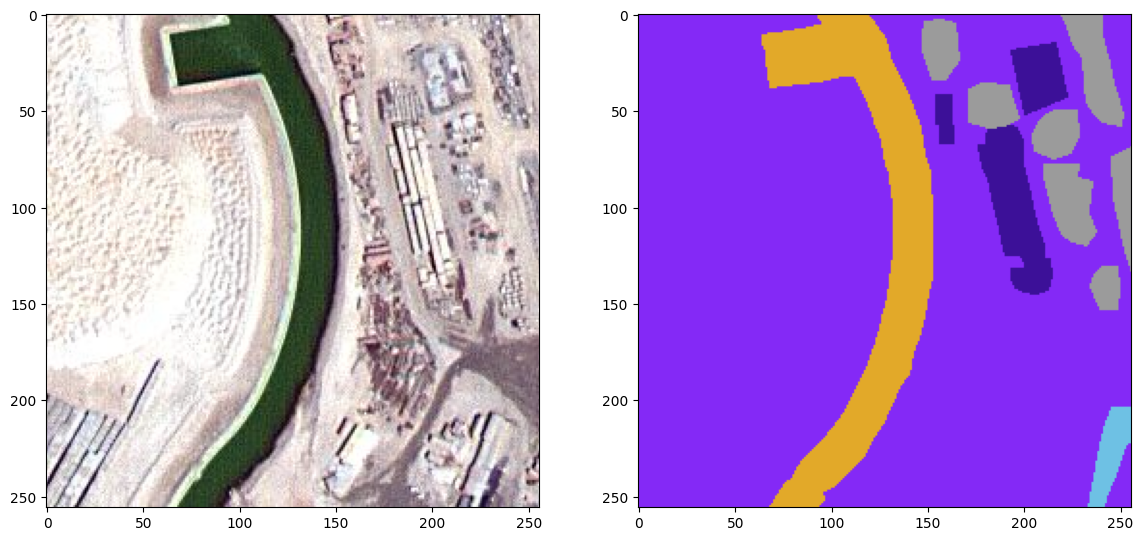

In [39]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(image_dataset[0])
plt.subplot(1,2,2)
plt.imshow(masks_dataset[0])

Now to actualy validate if the mask is corresponding to the image lets display random images (import random package)

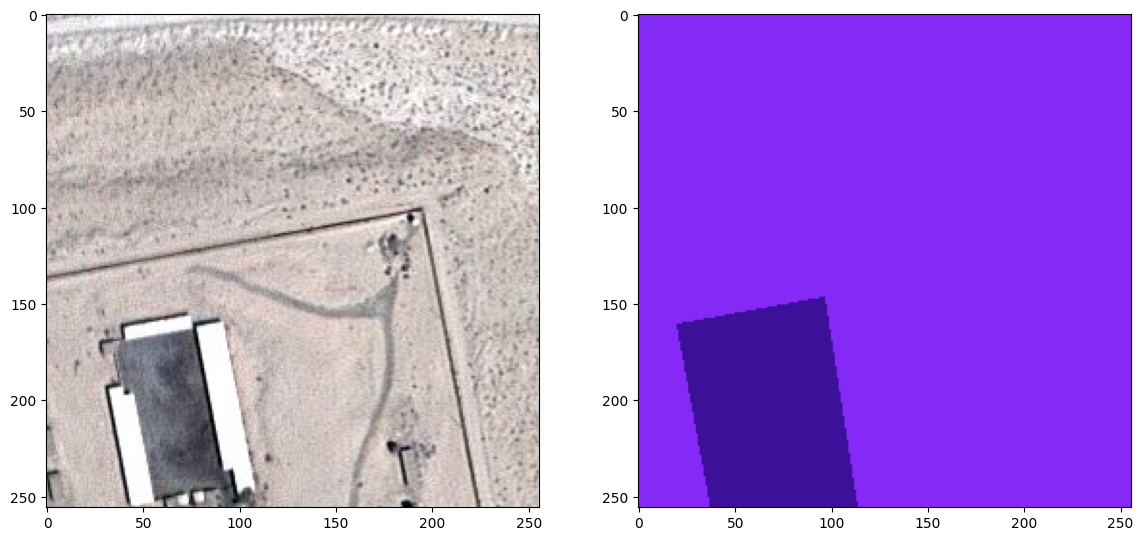

In [40]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(image_dataset[random_image_id])
plt.subplot(1,2,2)
plt.imshow(masks_dataset[random_image_id])

#Encoding Labels

In our data there is a json file that keep the classes and their properieties of masks.
classes contains:
```
number (from 0 to 5 wchich):
  - title: of the class in string
  - shape: of the goemetry (polygon) in string
  - color: of the class in HEX format
```

We need to perform One-Hot_encoding with Hex labels to set RGB label.

For example, the Hex format wchich is:
```
#D0021B
```
Coresponds to the RGB values where:
```
D0 -- Red
02 - Green
1B - Blue
```
On the kaggle page of the Dataset there is description of every class code:
```
Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B
```
So what we gonna to do now is to get the RGB values from Hex format.

In [41]:
class_building = '#3C1098'
class_building = class_building.lstrip('#') #Remove the Hash
#Create a RGB tuple by iterating over every pair in hexdecimal format the 16 here is to determine that this is the hexdecimal format. In this format The digits 0-9 have their usual values, and the letters A-F represent the values 10-15.
#Then we need to convert it to a numpy array.
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

[ 60  16 152]


For any confusion, this how it converts the pairs from Hexdecimal numering system:

---

$Hexdecimal.numering.system:$

$(1:9) = (1:9)$

$(A:F) = (10:15)$

examples:

$98= 9×16^1 + 8×16^0 = 144+8 =152$

$3C= 3×16^1 + 12×16^0 = 48+12 =60$

---
Now let's apply it to every class.

In [42]:
class_building = '#3C1098'
class_building = class_building.lstrip('#') #Remove the Hash
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

#Land
class_land = '#8429F6'
class_land = class_land.lstrip('#') #Remove the Hash
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

#Road
class_road = '#6EC1E4'
class_road = class_road.lstrip('#') #Remove the Hash
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

#Vegetation
class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

#Water
class_water = '#E2A929'
class_water = class_water.lstrip('#') #Remove the Hash
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

#Unlabeled
class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#') #Remove the Hash
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


Now we need to apply function that will convert the RGB values of the mask image to a labels.
```
TITLE:              |        HEX:         |     RGB:      |    LABEL:    |
....................|.....................|...............|..............|
Building:           |        #3C1098      | [ 60  16 152] |      3       |      
Land (unpaved area):|        #8429F6      | [132  41 246] |      1       |
Road:               |        #6EC1E4      | [110 193 228] |      2       |
Vegetation:         |        #FEDD3A      | [254 221  58] |      4       |
Water:              |        #E2A929      | [226 169  41] |      0       |
Unlabeled:          |        #9B9B9B      | [155 155 155] |      5       |
```
To do that we will create an array in shape of our mask image then we'are going to check The RGB values and assign to them coresponding class. So if the array elemnet (pixel), will be equal to RGB value of class Land, the array element will  update to 1. When it will be vegetation: 4 and so on...

In [43]:
# The label here is just the individual patched mask
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8) #creating an array that share the shape with the label and holds the integers
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [44]:
#Creating labels dataset
labels = []

#Every label must coresponds with the mask image. Let's iterate overy every mask image.
for i in range(masks_dataset.shape[0]):
  label = rgb_to_label(masks_dataset[i])
  labels.append(label)

#print(len(labels))

In [45]:
# Need to be sure the labels are numpy arrays
labels = np.array(labels)

In [46]:
labels=np.expand_dims(labels, axis=3)

In [47]:
labels[3]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [48]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

# Visualization of Labels and image

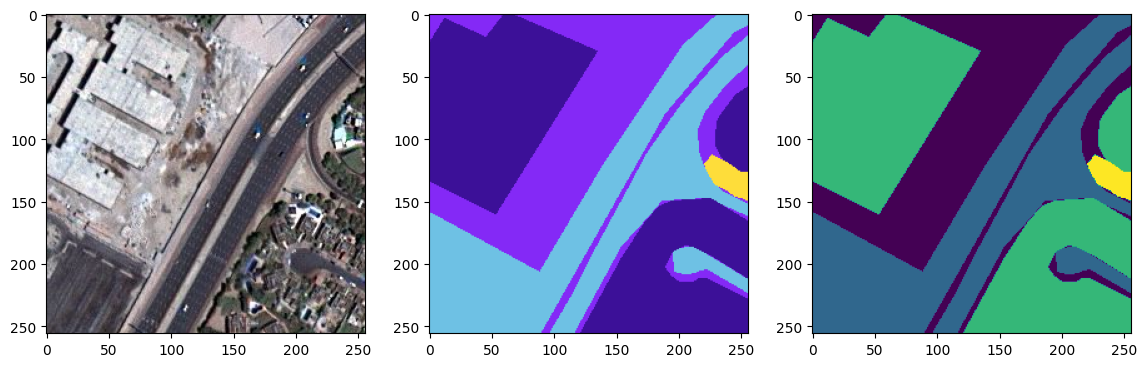

In [49]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
plt.imshow(image_dataset[random_image_id])
plt.subplot(1,3,2)
plt.imshow(masks_dataset[random_image_id])
plt.subplot(1,3,3)
plt.imshow(labels[random_image_id][:,:,0])

From left:
Satellite Image; Mask Image; Label Image.

The satellite image is just an image taken by MBRSC satellite.

Mask Image is a graphical representation of what is on the image i.e. Land or road or trucks.

Label Image is similar to mask image but here the pixel values corresponds to value of diffrent class.

The diference is that on Label image we expend the dimension with number of class. This number was calculated on RGB values of Mask Image.

---

# Train and Test Sets

In [50]:
master_training_dataset = image_dataset

For spliting the dataset into train and test data lets use **train_test_split()** from **sklearn.model_selection.**

We need to somehow describe the actual label of pixel.

To do that we can use to_categorical from Tensorflow. With this we are going to describe the class binary:

so the last dimension of labels dataset would be 6 (because we have 6 categories)  instead of 1(where we keep the number of class i.e. 3,5,1,2,0).


Now the last dimension will have 6 values and based on category one of them will have 1 and the rest 0. This is how we will represent the category from now.

In [51]:
total_classes = len(np.unique(labels))

In [52]:
#the last dimension is holding class number
labels.shape

(945, 256, 256, 1)

In [53]:
#How many classes we have in the dataset
print(total_classes)

6


In [54]:
# creating binary representation of classes
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [55]:
#the last dimension holds the binary representation of data
labels_categorical_dataset.shape

(945, 256, 256, 6)

Now we can split the Dataset into Test and Training

In [56]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.10, random_state=100)

In [57]:
#Let's check the Train and test sets sizes.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(850, 256, 256, 3)
(95, 256, 256, 3)
(850, 256, 256, 6)
(95, 256, 256, 6)


In [58]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [59]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


#U-NET

After we process the date it's time to hands on Deep learnig on Sattelite imagery.
We're gonna use U-NET.
U-Net is a convolutional neural network architecture designed for semantic segmentation tasks. It was introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their 2015 paper titled "U-Net: Convolutional Networks for Biomedical Image Segmentation."
Even if the U-NET was designed for Biomedical images we will apply it on satellite images.
Let's take a quick look on the architecture of this Newtwork. U-NET is verry effective on high resolution data like satellite imagery.

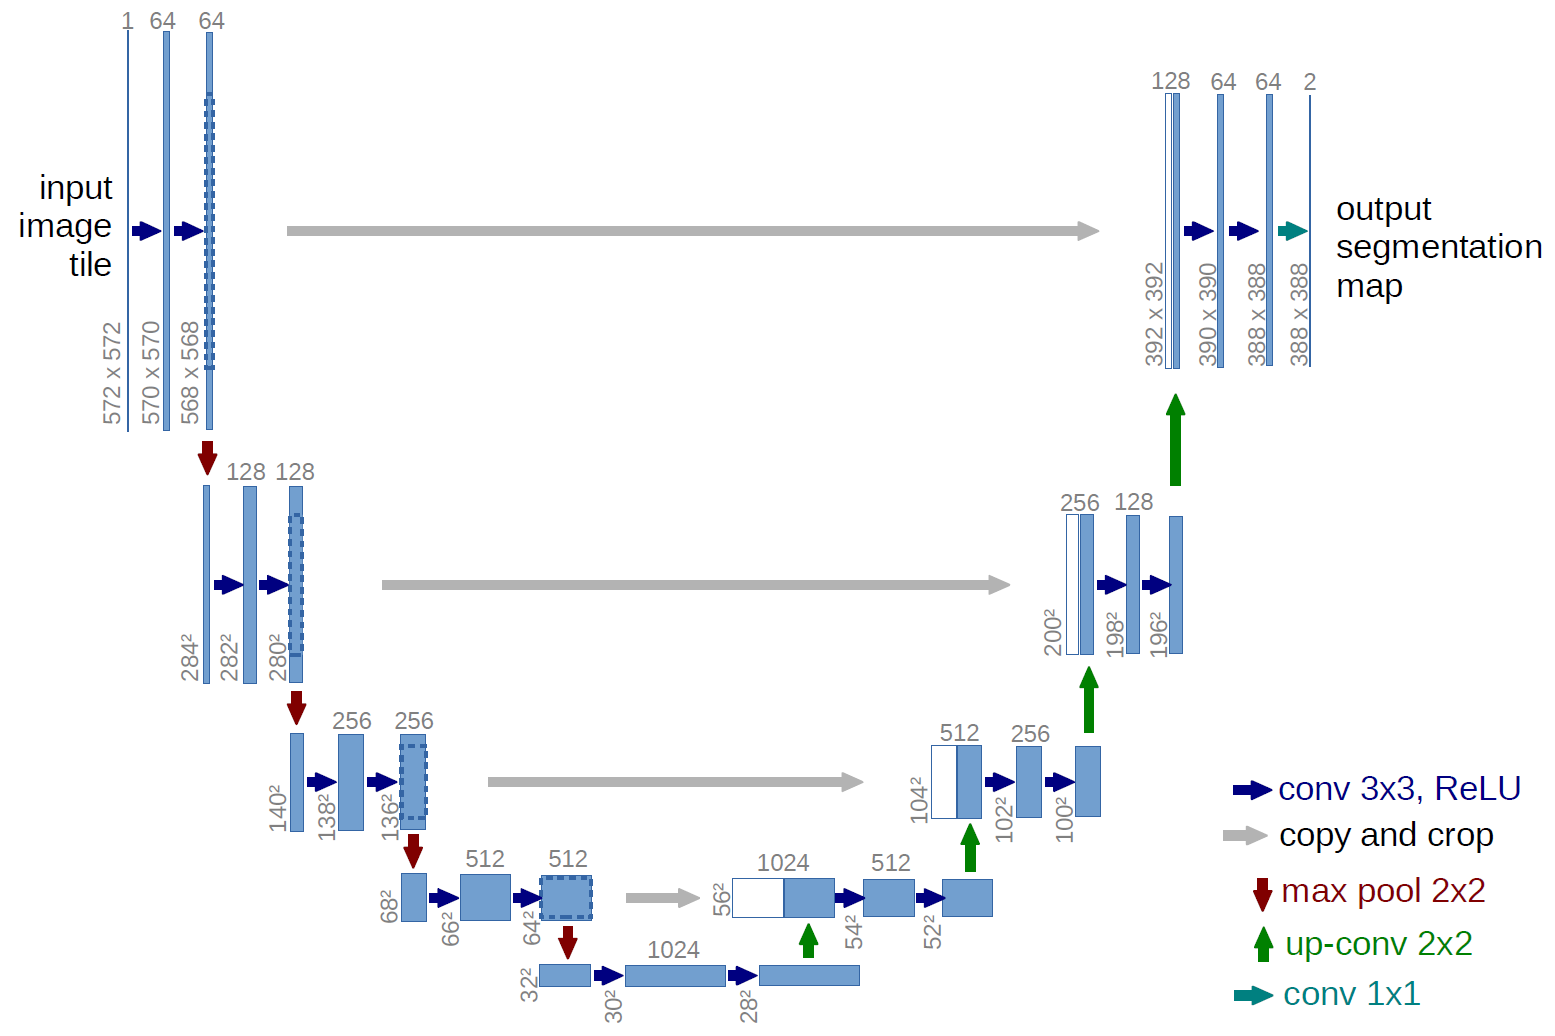

Lets describe how U-Net works.

U-NET is a Convolution Neural Network (CNN) that consist Encoder (left side) followed by Decoder (Right side).

The Encoder is build with 3 convolutional layers of 3x3 with ReLU activation function. After all convolutional layers there is Max pooling layer for downsampling and it doubles the channels. Encoder is responsible for extracting features from image.


Decoder, wchich can be simply described as a reverse of Encoder, is reasponsibility is to create an output (segmentation mask) based on upsampled features. Decoder also consist of 3x3 convonutional layers followed by upsampling 2x2 convolutional layer so the channels are reduced. Decoder function is to recognize which pixel is part of the feature.

As You can see the Encoder and Decoder are connected with each other. There is two type of these connections.

Connecting Paths (grey arrows) is concatination between shape of the processed image by encoder and upsampled feature of decoder. This means that on this stage Convonutional layers of Decoder can aslo operate on the encoder image to concatenate the feature area and pixels.

The bottleneck (the very bottom layer) is the place in the architecture where encoder switch to decoder. What it do is downsampling once again with max pooling layer 2x2 so it double the channels, then it repeat a convolutional layer with ReLU and then upsample with 2x2 convolutional layer to the previous resolution.

Watch the video to better understand the U-NET architecture: https://youtu.be/NhdzGfB1q74?si=zaWNFrYp5blag_PA

Or read the Paper: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

# Model & Evaluation Metrics

We need to import some features from Keras:

```
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
```


And also in seperate line:
```
from keras import backend as K
```

seperate line because keras is a highlevel Model label library. And when it comes to applying deep learning on tensors (beacause our data are tenrsors) and in keras backend can be anything. By writing this line we can chose the backend for calculations..  

Creating an model is obviously important but also important is to evaluate it. Let's look at the evaluation metrics that we will use.
In deep learning tasks metrics like accuracy is very common to use. However, in this segmentation task we will use Jaccard index.
Jaccard index is measuring similarity between two sets. It is defined as the size of the intersection of the sets divided by the size of the union of the sets.

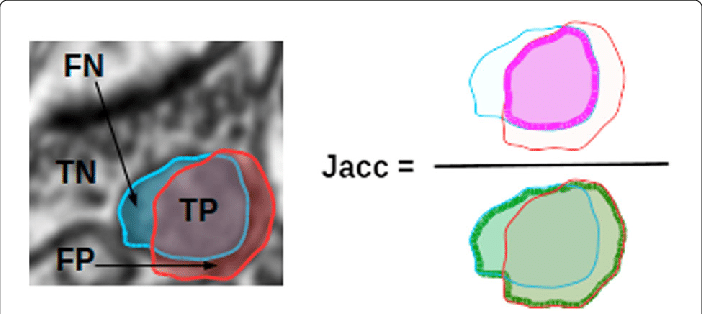

So the best Jaccard index is when the model estimated area is fully overlaping the true area. In tht case it will be equal to 1.


In [60]:
def jaccard_index(y_true,y_pred):
  y_true_flatten= K.flatten(y_true) #This will "flatten" multi dimensional data into 1D
  y_pred_flatten= K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten)-intersection + 1.0)
  return final_coef_value

#U-Net Architecture

Let's create the architecture of U-Net

In [61]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1): # parameters of the function with defaul values. For image_chanels value we set the 1 wchich is corresponds to greyscale image, but it is minimum.
  # let's create the Input of the network and folewed by it layers from U-Net.
  #It's important to look at the default values of parameters, because for example:
  #the activation function in U-net is ReLu function and the convolution stride is 3x3.
  #In the Conv2D activation fucntion default value is none and the stride is 1x1.
  # but we will add some changes. We will apply 16 filters not 64.

  inputs = Input((image_height,image_width,image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1) #this dropout layer prevent network from overfitting
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  # thats it. Now we have the top left part of the network. lets move below with Maxpooling
  p1 = MaxPooling2D((2,2))(c1)

  #According to the architecture we double the filters. Instead of 16 we have 32.
  c2 =  Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 =  Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 =  Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 =  Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6,c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7,c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8,c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9,c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2DTranspose(n_classes, (1,1), activation="softmax")(c9)
  model = Model(inputs=[inputs], outputs=[outputs])
  return model


In [62]:
metrics = ['accuracy', jaccard_index]

In [63]:
#Defining a function that called a model. Its easiest for debuging
def get_deep_learning_model():
  return multi_unet_model(n_classes = 6,
                          image_height = image_height,
                          image_width= image_width,
                          image_channels=image_channels)

In [64]:
model = get_deep_learning_model()

#Debuging method & example:

An error occured. It said that:
```

ValueError: A `Concatenate` layer should be called on a list of at least 1 input. Received: input_shape=(None, 128, 128, 32)
```
Let's take a look at the code and try to find the layer that cause the problem:

For that purpose let's comment every layer in the model except first one.

Next step is to create a temporary output wchich will take the output value based on that layer.

when we run the code it will run the non-comment layer. And if there is no problem there is no error. Let' move with this method next layer and next and next...


```
....
c5 =  Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)
  
u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6 = concatenate(u6,c4)
c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

# u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
# u7 = concatenate([u7,c3])
# c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
# c7 = Dropout(0.2)(c7)
....

```
And the output now is taking the c6:
```
outputs = Conv2DTranspose(n_classes, (1,1), activation="softmax")(c9)
```

Error Occured:
```
ValueError: A `Concatenate` layer should be called on a list of at least 1 input. Received: input_shape=(None, 128, 128, 32)
```

This is because when I created concatenation layer i didnt put a list of layers i want to concatenate so instead of this:
```
u8 = concatenate([u6,c4])
```
i wrote something like that:
```
u8 = concatenate(u6,c4)
```

That is the error. And creating a function that calls the model is game changing in debugging process. Because you don't need to define all the parameters again and again to run the model.
Also going from top to bottom in your model by activation each part of the code its very useful and efective.

# Loss function

In Machine Learning and deep learning tasks we need to know how our model is performing. To get an overview in how good our model is we need to know how it predict ground truth values.
Briefly, the loss function is measuring the diference between model prediction and ground truth values.

In this project we will use Cross Entropy loss extension that is Focal loss.

But why? what properieties the focal loss function have that we want to use?

Simply, because in Focal loss we're gonna set equal weights to every class. The reason is distribution of the classes on our imagery.
f.e. We have a class of bare ground and class of cars. If we just imagine a satellite image of single car and around it is the bare ground. The model will pay more attention to the bare ground and in consequences the weights of these two classes will be diffrent. we don't want that. We want our model to pay the same "attention" to every class not just for the classes that occuring more frequently.

Now let's set the weights.

In [65]:
#We have 6 classes so we just simply divide 1 by six to get the weights = 0.1666
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

To generate the loss function we will use **segmentation losss** library.
```
import segmentation_models as sm
```

Knowing that our loss function will be calculated like this:

Set the weights > Dice Loss > Focal Loss > Total loss

we will use formula:
```
Total loss = (Dice loss + (1*Focal loss)
```

Dice loss - measures the similarity between predicted and true binary masks.

Focal loss - is designed to address class imbalance problems, where one class is much more prevalent than the other.


In [66]:
#there was a problem when you import the segmentation library because import refers to keras not tensorflow keras.
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [67]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [68]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)

In [69]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [70]:
total_loss = dice_loss + (1*focal_loss)

#Model Compilation

In [71]:
import tensorflow as tf

In [72]:
#We need to set the backend for the model
tf.keras.backend.clear_session()

In [73]:
# compilation of the model requiered 3 parameter: optimizer wchich we will chose adam for classification task, loss function wchich we generated above, and metrics wchich we defined as list of [accuracy and jaccard coeficiant]
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [74]:
# let's generate model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

#Test Training & Full Scale Training

In [75]:
model_history = model.fit(X_train,y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=200,
                          validation_data=(X_test,y_test),
                          shuffle=False)

Epoch 1/200
54/54 [==============================] - 24s 103ms/step - loss: 0.9969 - accuracy: 0.5728 - jaccard_index: 0.2775 - val_loss: 0.9867 - val_accuracy: 0.6894 - val_jaccard_index: 0.3177
Epoch 2/200
54/54 [==============================] - 4s 67ms/step - loss: 0.9725 - accuracy: 0.7025 - jaccard_index: 0.4066 - val_loss: 0.9705 - val_accuracy: 0.6842 - val_jaccard_index: 0.4337
Epoch 3/200
54/54 [==============================] - 4s 68ms/step - loss: 0.9588 - accuracy: 0.7292 - jaccard_index: 0.4747 - val_loss: 0.9728 - val_accuracy: 0.6889 - val_jaccard_index: 0.4589
Epoch 4/200
54/54 [==============================] - 4s 67ms/step - loss: 0.9513 - accuracy: 0.7487 - jaccard_index: 0.5040 - val_loss: 0.9834 - val_accuracy: 0.6541 - val_jaccard_index: 0.4414
Epoch 5/200
54/54 [==============================] - 4s 66ms/step - loss: 0.9474 - accuracy: 0.7594 - jaccard_index: 0.5248 - val_loss: 0.9843 - val_accuracy: 0.6480 - val_jaccard_index: 0.4345
Epoch 6/200
54/54 [=========

KeyboardInterrupt: ignored

In [ ]:
history_a = model_history

According to RAM limitations on CPU and GPU. That model was trained using TPU (because it work) but the runtime is very long.
This model has only 10 epochs and the runtime was about 2.5 hours. From that point i choose to use Colab Pro with more computional power and memory. If the cell above crash its simply run out of resources.

This model was trained on V100. I change number of Epochs from 10 to 200.
![Unet_CAS.png](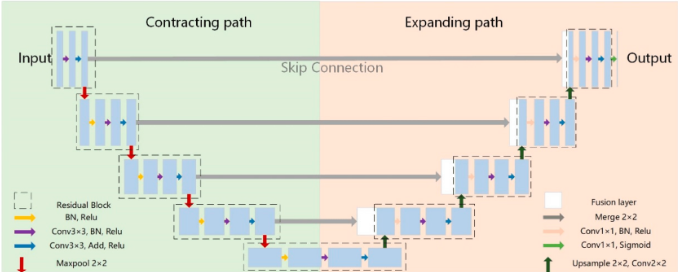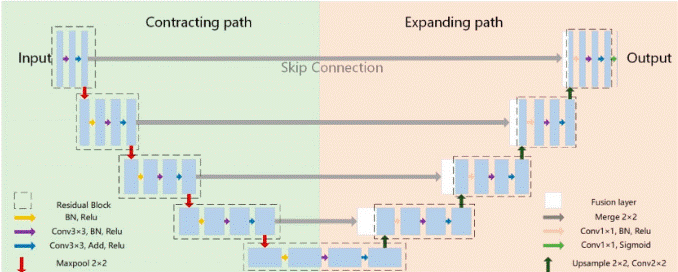)

#Validation

Let's validate our model. By looking at he plots down.

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

On this Plot we compare the loss function during Traing and validating of model.On Y axis is the value of the loss function (How the predicted values is close to the ground truth targets.), On X axis is the epoch.
The value of loss function is coresponding to an epoch.

while analyzing this plot we can tell that after 60' epoch the loss function in  validation didn't go lower, and oscilates between 94 and 91 values. To improve the performance of the model we need to experiment with the layers of our model. f.e. changing the dropout value.

The target here is to minimize the value of the function.

In [ ]:
jaccard_coef = history_a.history['jaccard_index']
val_jaccard_coef = history_a.history['val_jaccard_index']

loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs= range(1,len(jaccard_coef)+1)
plt.plot(epochs,jaccard_coef,'y',label="Training IoU")
plt.plot(epochs,val_jaccard_coef,'r',label="Validation IoU")
plt.title('Training vs Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

Above is a graphical interpretation of IoU (Intersection over Union - Jaccard Index). On X axis again is epochs, but on the Y is the value of IoU (If the predicted area is overlaping with ground truth area the Jaccard index is 1)

The value of IoU is around 0.7 and 0.8 which is good but if we want to improve it we experiment with the parameters to maximize this index.

In [ ]:
model_history.params

Let's describe these parameters:

verbose is a parameter how do you want to visualize the proces of training. it is set to 1 meaning we will see the bar during the training wchich batch is training now and all additional information.

Epochs is how many times our network will operate over the dataset. Set up here 200 so the network will "feed" itself with whole dataset 200 times.

steps is how many batches is in one epoch. If our training dataset contains over 800 images and we create a model wich will take 16 images in one batch there will be 54 batches.

1 epoch -> 54 batches -> 1 batch -> 16 images

#Prediction

In [ ]:
#prediction of the model
y_pred = model.predict(X_test)

In [ ]:
#let's see how it looks like -- values are propabilities of the class so we need to get the maximum value
y_pred[0]

In [ ]:
#Let's check that all images are predicted.
len(y_pred)

In [ ]:
# We want to get our maximum value
y_pred_argmax = np.argmax(y_pred,axis= 3)

In [ ]:
# Now we have our classes
y_pred_argmax

In [ ]:
# Let's get the classes of our test set
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

We can see the difrence in y_pred_argmax and y_test_argmax now.

#Prediction results

In [ ]:
test_image_number = random.randint(0,len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

#We need to expand dimensions if we want to compare predicted and ground truth image
test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction,axis=3)
predicted_image = predicted_image[0,:,:]

In [ ]:
predicted_image

In [ ]:
#Let's print the variables to see how they look like.
test_image

In [ ]:
test_image_input

In [ ]:
prediction

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(test_image)

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(ground_truth_image)

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(predicted_image)

Now we can see the difrence more better than with just numbers.

#Saving the model


In [ ]:
model.save("satellite_segmentation_prodramp.h5")

In [ ]:
!ls -lah

#Diffrent Architectures of U-NET

Redesigning the architecture of U-NET can improve our model performance let's look at diffrent type of the architectures from papers, articles or GitHub repositories.

##U-NET - University of Chinese Academy of Sciences

Source:https://www.mdpi.com/2072-4292/14/3/487

Scientists from University of Chinese Academy of Sciences write a paper in wchich they applying redesigned U-NET infrastructure to detect crevasses on SAR imagery.

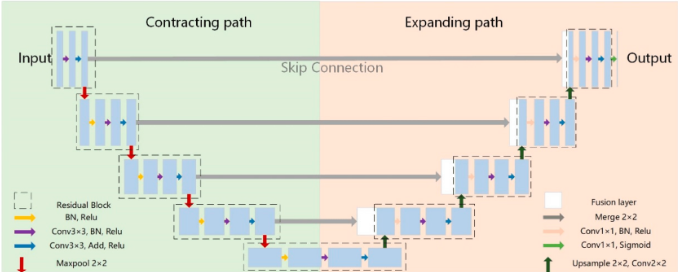

## U-NET - Alex Mathai

Source: https://github.com/Alex-Mathai-98/Satellite-Image-Segmentation-Using-U-NET

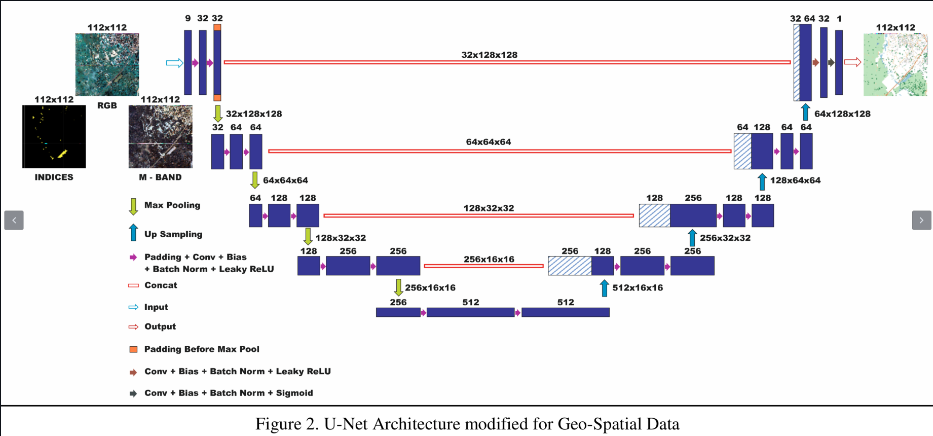

##U-NET - Vooban

Source: https://medium.com/vooban-ai/satellite-image-segmentation-a-workflow-with-u-net-7ff992b2a56e

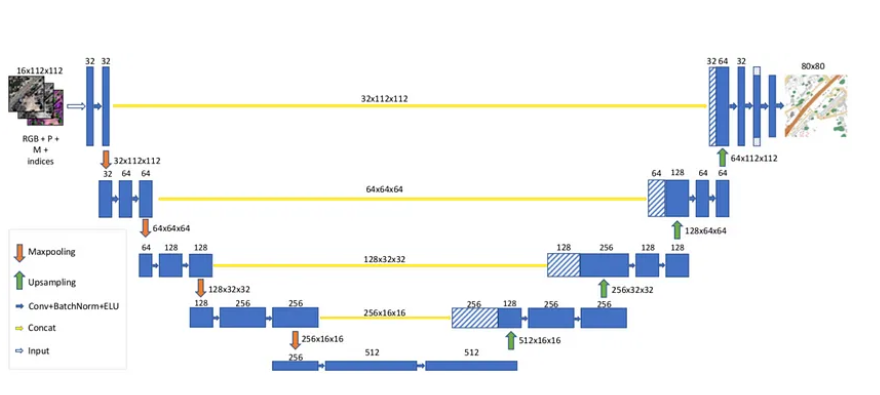